# Introduction
## What is mean reversion?
A mean reversion algorithm is a quantitative trading strategy based on the idea that asset prices and returns tend to move back towards their historical average or mean over time. When prices deviate significantly from this average, the algorithm identifies potential buy or sell opportunities, anticipating that prices will revert to the mean.

## Aim

The aim with this project is to develop a successful mean reversion algorithm which beats, or performs similarly, to the S&P 500 index which annually currently returns on average 10.33% (nominal). Development will take an iterative approach, refining previous strategies, datasets and parameters to improve the results yielded from the previous iteration

In [52]:
import yfinance as yf
from curl_cffi import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [53]:
session = requests.Session(impersonate="chrome") # To fix yfinance rate limitter bug
ticker = yf.Ticker("MSFT",session=session)

# Data Cleansing

In [54]:
msft_historical_data = pd.read_csv("msft_00-20.csv")
msft_historical_data = msft_historical_data.drop(columns=["Open","High","Low","Dividends","Stock Splits"]) # Remove unnecessary Columns
msft_historical_data.dropna()

msft_historical_data["Date"] = pd.to_datetime(msft_historical_data["Date"],utc=True)

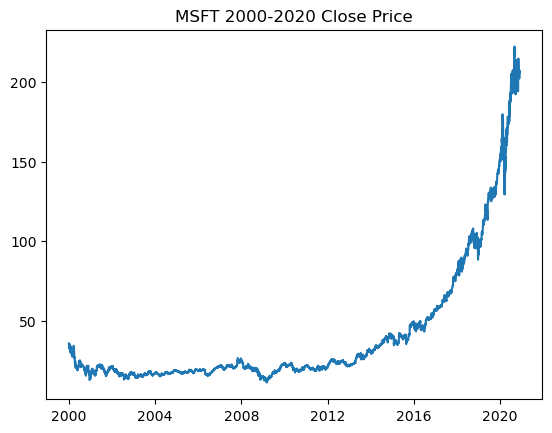

In [55]:
plt.plot(msft_historical_data["Date"],msft_historical_data["Close"])
plt.title("MSFT 2000-2020 Close Price")
plt.show()

# Mean Reversion Algorithm

In [56]:
# Create simple moving average column (2 week)
msft_historical_data["SMA"] = (msft_historical_data["Close"].rolling(14).sum()) / 14
msft_historical_data.dropna()

,Date,Close,Volume,SMA
13,2000-01-21 05:00:00+00:00,31.799646,68416200,33.802869
14,2000-01-24 05:00:00+00:00,31.033401,63597600,33.467632
15,2000-01-25 05:00:00+00:00,31.512310,59823200,33.252807
16,2000-01-26 05:00:00+00:00,30.458708,49365000,32.936726
17,2000-01-27 05:00:00+00:00,30.267136,63654800,32.690429
...,...,...,...,...
5257,2020-11-23 05:00:00+00:00,202.318283,25683500,207.117443
5258,2020-11-24 05:00:00+00:00,205.929214,33979700,206.982293
5259,2020-11-25 05:00:00+00:00,205.938812,21012900,206.374488
5260,2020-11-27 05:00:00+00:00,207.248428,14512200,205.830729


In [57]:
# Create standard deviation column over 2 week
msft_historical_data["Std_deviation"] = msft_historical_data["Close"].rolling(14).std()

In [58]:
msft_historical_data["Buy/Sell"] = np.where(msft_historical_data["Close"] > msft_historical_data["SMA"] + (msft_historical_data["Std_deviation"] * 2),"Sell",
                                            np.where(msft_historical_data["Close"] < msft_historical_data["SMA"] - (msft_historical_data["Std_deviation"] * 2),"Buy","Neither" ))
msft_historical_data = msft_historical_data.dropna()

# Returns

In [59]:
def calculateGain(row, df:pd.DataFrame):
    indexesOfNextFiveDays = row.name + 5 # row.name = row's index
    if indexesOfNextFiveDays < len(df):
        prices = df.iloc[row.name:indexesOfNextFiveDays]
        target_yield = 0.03 # 3% yield threshold
        exit_price = prices.iloc[-1]["Close"]
        entry_price = row["Close"]

        if row["Buy/Sell"] == "Buy":
            best_price = row["Close"] + (row["Close"] * target_yield)
            for index, prices_row in prices.iterrows():
                if prices_row["Close"] >= best_price:
                    exit_price = prices_row["Close"]
                    return(exit_price - entry_price)/ entry_price * 100
            return (exit_price - row["Close"])/row["Close"] * 100
            
        elif row["Buy/Sell"] == "Sell":
            best_price = row["Close"] - (row["Close"] * target_yield)

            for index, prices_row in prices.iterrows():
                if prices_row["Close"] <= best_price:
                    exit_price = prices_row["Close"]
                    return(entry_price - exit_price)/ entry_price * 100
                
            return(entry_price - exit_price)/ entry_price * 100
        else:
            return 0
        
    else:
        return None


In [60]:
msft_historical_data["Gain/Loss"] = msft_historical_data.apply(calculateGain, axis=1, args=(msft_historical_data,)) # Trailing comma makes it a tuple - required

In [61]:
msft_historical_data[msft_historical_data["Buy/Sell"] != "Neither"]

,Date,Close,Volume,SMA,Std_deviation,Buy/Sell,Gain/Loss
46,2000-03-09 05:00:00+00:00,30.650269,88198800,28.668950,0.847914,Sell,9.125012
47,2000-03-10 05:00:00+00:00,30.956766,85589000,28.798940,1.042372,Sell,10.024749
56,2000-03-23 05:00:00+00:00,34.289978,148224000,30.180934,1.620722,Sell,25.027895
57,2000-03-24 05:00:00+00:00,34.232525,112196800,30.642057,1.793284,Sell,28.931186
77,2000-04-24 04:00:00+00:00,20.420746,313645800,24.813037,1.911503,Buy,3.283303
...,...,...,...,...,...,...,...
5196,2020-08-27 04:00:00+00:00,217.607819,57602200,203.869862,5.814981,Sell,9.502168
5197,2020-08-28 04:00:00+00:00,219.845505,26292900,205.321587,7.051397,Sell,11.358164
5227,2020-10-12 04:00:00+00:00,212.632919,40461400,201.079985,4.937389,Sell,7.533883
5228,2020-10-13 04:00:00+00:00,214.035126,28950800,202.607711,5.413348,Sell,9.149244


# Visualise Returns

In [62]:
totalReturn = msft_historical_data["Gain/Loss"].sum()
print("Total Return: ", totalReturn,"%")

Total Return:  -18.141583882828584 %


In [63]:
msft_historical_data["Cumulative Returns"] = msft_historical_data["Gain/Loss"].cumsum()

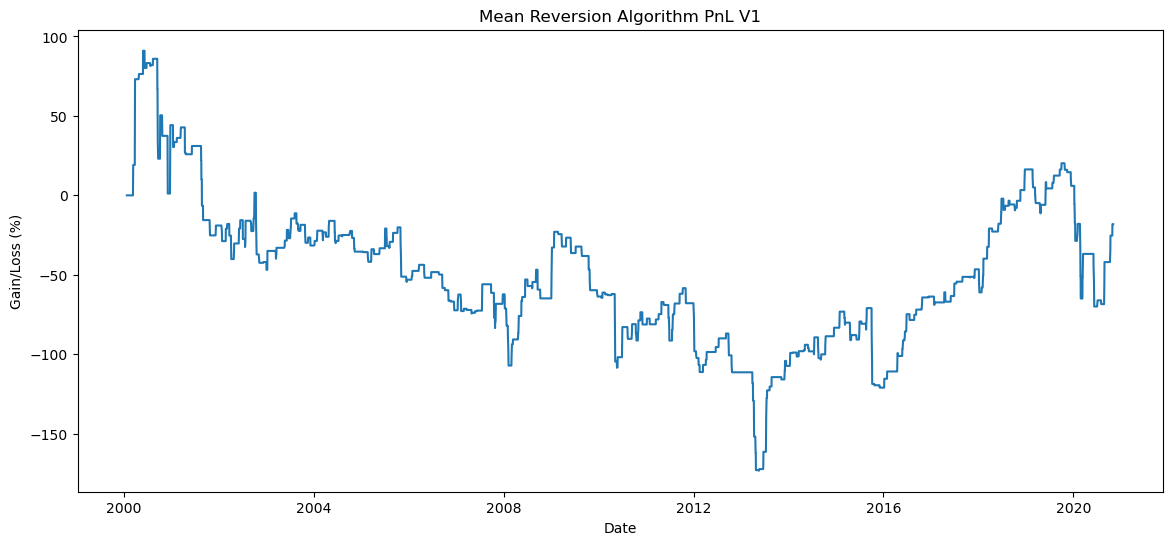

In [64]:
plt.figure(figsize=(14,6))
plt.plot(msft_historical_data["Date"],msft_historical_data["Cumulative Returns"])
plt.ylabel("Gain/Loss (%)")
plt.xlabel("Date")
plt.title("Mean Reversion Algorithm PnL V1")
plt.show()

## YoY Returns

In [71]:
first_recorded_year = msft_historical_data["Date"].dt.year.min()
most_recent_year = msft_historical_data["Date"].dt.year.max()

current_year = first_recorded_year
while (current_year <= most_recent_year):
    current_year_data = msft_historical_data[msft_historical_data["Date"].dt.year == current_year]
    num_trades_placed = current_year_data[current_year_data["Buy/Sell"] != "Neither"].shape[0]

    print ("Year: ",current_year)
    print("Annual Return", current_year_data["Gain/Loss"].sum())
    print("# of Trades Placed: ", num_trades_placed)
    print("\n")

    current_year += 1

print("\nAverage YoY Return: ", totalReturn / 20)

Year:  2000
Annual Return 23.920443921333927
# of Trades Placed:  75


Year:  2001
Annual Return -118.92344342201974
# of Trades Placed:  62


Year:  2002
Annual Return 59.11898731891914
# of Trades Placed:  60


Year:  2003
Annual Return 106.97947744970335
# of Trades Placed:  66


Year:  2004
Annual Return 1.979816259807782
# of Trades Placed:  64


Year:  2005
Annual Return -85.81392243161895
# of Trades Placed:  81


Year:  2006
Annual Return -41.70874724288676
# of Trades Placed:  66


Year:  2007
Annual Return -37.808734057891556
# of Trades Placed:  68


Year:  2008
Annual Return 41.58980397808601
# of Trades Placed:  53


Year:  2009
Annual Return 77.66168527618099
# of Trades Placed:  66


Year:  2010
Annual Return 20.01987814034763
# of Trades Placed:  70


Year:  2011
Annual Return 30.97053851456285
# of Trades Placed:  65


Year:  2012
Annual Return -16.226483817862533
# of Trades Placed:  61


Year:  2013
Annual Return -105.43264929912769
# of Trades Placed:  62


Year:  2

# Iteration 1: Results Summary
- The mean reversion algorithm was applied to Microsoft (MSFT) from 2000 to 2020.
- On average, 22 trades were placed per year
- The most profitable year was 2003 at 106%
- The least profitable year was 2001, with a loss of -118%
- Total return was -18.1%


# Mean Reversion Algorithm - v2
- In the first iteration, an average of only 22 trades were placed per year — less than two trades per month. This low trade frequency may have contributed to the large fluctuations in annual returns. In the second iteration, we will adjust the SMA window and the standard deviation multiplier to lower the threshold for making trades and increase trading activity.

In [66]:
msft_historical_data["Buy/Sell"] = np.where(msft_historical_data["Close"] > msft_historical_data["SMA"] + (msft_historical_data["Std_deviation"] * 1.5),"Sell",
                                            np.where(msft_historical_data["Close"] < msft_historical_data["SMA"] - (msft_historical_data["Std_deviation"] * 1.5),"Buy","Neither" ))
msft_historical_data = msft_historical_data.dropna()

In [67]:
# Recalculate gains and losses
msft_historical_data["Gain/Loss"] = msft_historical_data.apply(calculateGain, axis=1, args=(msft_historical_data,)) # Trailing comma makes it a tuple - required

# Recalculate total returns
totalReturn = msft_historical_data["Gain/Loss"].sum()
print("Total Return: ", totalReturn,"%")

# Recalculate cumulative returns
msft_historical_data["Cumulative Returns"] = msft_historical_data["Gain/Loss"].cumsum()

Total Return:  -113.63870430580822 %


In [68]:
first_recorded_year = msft_historical_data["Date"].dt.year.min()
most_recent_year = msft_historical_data["Date"].dt.year.max()

current_year = first_recorded_year
while (current_year <= most_recent_year):
    current_year_data = msft_historical_data[msft_historical_data["Date"].dt.year == current_year]
    num_trades_placed = current_year_data[current_year_data["Buy/Sell"] != "Neither"].shape[0]

    print ("Year: ",current_year)
    print("Annual Return", current_year_data["Gain/Loss"].sum())
    print("# of Trades Placed: ", num_trades_placed)
    print("\n")

    current_year += 1

print("\nAverage YoY Return: ", totalReturn / 20)

Year:  2000
Annual Return 23.920443921333927
# of Trades Placed:  75


Year:  2001
Annual Return -118.92344342201974
# of Trades Placed:  62


Year:  2002
Annual Return 59.11898731891914
# of Trades Placed:  60


Year:  2003
Annual Return 106.97947744970335
# of Trades Placed:  66


Year:  2004
Annual Return 1.979816259807782
# of Trades Placed:  64


Year:  2005
Annual Return -85.81392243161895
# of Trades Placed:  81


Year:  2006
Annual Return -41.70874724288676
# of Trades Placed:  66


Year:  2007
Annual Return -37.808734057891556
# of Trades Placed:  68


Year:  2008
Annual Return 41.58980397808601
# of Trades Placed:  53


Year:  2009
Annual Return 77.66168527618099
# of Trades Placed:  66


Year:  2010
Annual Return 20.01987814034763
# of Trades Placed:  70


Year:  2011
Annual Return 30.97053851456285
# of Trades Placed:  65


Year:  2012
Annual Return -16.226483817862533
# of Trades Placed:  61


Year:  2013
Annual Return -105.43264929912769
# of Trades Placed:  62


Year:  2

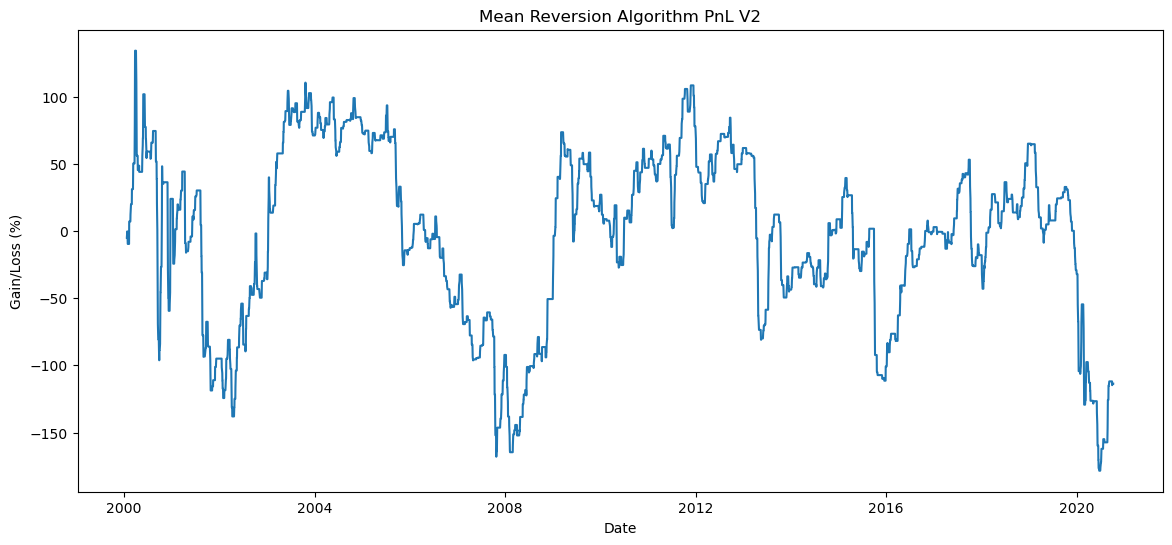

In [69]:
plt.figure(figsize=(14,6))
plt.plot(msft_historical_data["Date"],msft_historical_data["Cumulative Returns"])
plt.ylabel("Gain/Loss (%)")
plt.xlabel("Date")
plt.title("Mean Reversion Algorithm PnL V2")
plt.show()

# Version 2: Results Summary
- The multiplier applied to the standard deviation value was lowered from 2 to 1.5
- ROI decreased further to -113.6%
- Approximately 65 trades were placed a year

In [70]:
# Remove timezone information from Date column before saving to Excel
msft_historical_data["Date"] = msft_historical_data["Date"].dt.tz_localize(None)
# Save to Excel
msft_historical_data.to_excel("msft_results.xlsx", index=False)